![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example app")
import pycountry
import requests
import json

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

## Первичный анализ DF

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
43124,id_1237,Barcelona,"['Spanish', 'Vegetarian Friendly', 'Vegan Opti...",1238.0,$$ - $$$,172.0,"[['Lovely!', 'Great Little Restaurant/Bar'], [...",/Restaurant_Review-g187497-d10533196-Reviews-V...,d10533196,1,4.0
14149,id_60,Amsterdam,"['New Zealand', 'Cafe', 'European', 'Contempor...",61.0,$$ - $$$,1091.0,"[['Great place for breakfast', 'Great food, at...",/Restaurant_Review-g188590-d4173529-Reviews-Ba...,d4173529,1,4.5
8731,id_8731,Paris,NaN,12486.0,NaN,5.0,"[[""Ok place for a drink but don't go there to....",/Restaurant_Review-g187147-d12130128-Reviews-B...,d12130128,0,0.0
23146,id_3245,Barcelona,"['Argentinean', 'South American', 'Steakhouse'...",3246.0,$$ - $$$,17.0,"[['Great Food', 'Another good spot !'], ['07/1...",/Restaurant_Review-g187497-d11980779-Reviews-L...,d11980779,1,4.0
46768,id_264,Prague,"['Bar', 'European', 'Czech', 'Eastern European...",265.0,$$ - $$$,1767.0,"[['Big Portions - Good Value', 'Lovely food/ g...",/Restaurant_Review-g274707-d694912-Reviews-Kol...,d694912,1,4.0


In [14]:
for i in list(data.columns):
    display(len(data[i].unique()))

13094

31

10732

12975

4

1574

41858

49963

49963

2

10

Так как уникальных значений ID_TA и URL_TA меньше 50,000, данные могут содержать дубликаты

In [15]:
#Создание DF содежащего дубликаты по признаку ID_TA
duplicates=data[data.ID_TA.duplicated() == True].sort_values(by ='ID_TA')
duplicates

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
48946,id_3242,Madrid,NaN,3244.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
28388,id_1229,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1231.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,1,4.0
36920,id_1800,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,1,3.5
23576,id_1277,Madrid,"['Asian', 'Thai', 'Vegetarian Friendly']",1279.0,$$ - $$$,70.0,"[['Delicious soup', 'My weekly treat'], ['03/1...",/Restaurant_Review-g187514-d10440367-Reviews-B...,d10440367,1,4.0
21583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...",3812.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463,1,4.0
36551,id_3240,Madrid,NaN,3242.0,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990,1,4.5
22628,id_2329,Madrid,NaN,2331.0,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719,1,4.5
39879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3664.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956,1,4.0
46074,id_2973,Madrid,NaN,2975.0,NaN,229.0,"[['Good Paella', 'Good enough. Nothing more'],...",/Restaurant_Review-g187514-d1235635-Reviews-Re...,d1235635,1,3.5
48967,id_1238,Madrid,"['Indian', 'Asian', 'Nepali', 'Vegetarian Frie...",1240.0,$$ - $$$,22.0,"[['Fantastic food, Excellent service', 'Surpri...",/Restaurant_Review-g187514-d12488993-Reviews-K...,d12488993,1,5.0


In [16]:
duplicates.City.unique()

array(['Madrid', 'Warsaw'], dtype=object)

Судя по всему, данные задвоеннны по City == Madrid|City == Warsaw

In [17]:
difference_check = []
for i in list(duplicates.ID_TA):
    # Ниже вычисление разницы в целевой переменной для дубликатов
    dif = list(data[data.ID_TA == i].Rating)[0] - list(data[data.ID_TA == i].Rating)[1]
    difference_check.append(dif)
difference_check

[0.0,
 -4.0,
 -3.5,
 -4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -3.5,
 -5.0,
 0.0,
 0.0,
 -4.0,
 -4.0,
 -3.5,
 0.0,
 -3.5,
 0.0,
 -4.0,
 -3.5,
 0.0,
 -4.5,
 0.0,
 -3.5,
 -4.0,
 -3.5,
 -3.5,
 0.0,
 0.0,
 0.0,
 0.0,
 -5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [18]:
duplicates.Rating.value_counts()

4.0    14
3.5    11
4.5     6
5.0     6
Name: Rating, dtype: int64

Разница в целевой переменной между дублями варируется в том же диапазоне, что и переменная в срезе

In [19]:
data[data.ID_TA == duplicates.ID_TA.iloc[0]]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
23980,id_3239,Madrid,NaN,3241.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
48946,id_3242,Madrid,NaN,3244.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0


In [20]:
data[data.ID_TA == duplicates.ID_TA.iloc[1]]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
4534,id_4534,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1253.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,0,0.0
28388,id_1229,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1231.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,1,4.0


Судя по всему, разница между некоторыми дублями объясняется тем, что они распределены между файлами kaggle_task и main_task.

Имеет смысл создать переменную, которая обозначит, что у строки есть дубль

### 1. Отметка дубликатов

In [21]:
# Помечаем новыми пизнаками превые и последние дубликаты
data['1'] = data.ID_TA.duplicated(keep='first')
data['2'] = data.ID_TA.duplicated(keep='last')

In [22]:
# Функция обрабатывает всмогательные столюцы и возвращает 1 для строк имеющих дубли
def duplicate(row):
    result = 0
    if row['1'] == True:
        result = 1
    elif row['2'] == True:
        result = 1
    return result

In [23]:
# Применение функции
data['has_duplicate'] = data.apply(duplicate, axis = 1)

In [24]:
# Удаление вспомогательных столбцов
data.drop(['1','2'], axis = 'columns', inplace = True)

# Cleaning and Prepping Data 
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## Анализ, преобразование и заполнение признаков

### Restaurant_id

### 2. Предположительные сети ресторанов

In [25]:
# Создание серии содержащей ID и кол-во ресторанов
id_vc = data.groupby(['Restaurant_id']).Ranking.count()
id_vc

Restaurant_id
id_0       16
id_1       10
id_10      15
id_100     13
id_1000    12
           ..
id_9995     3
id_9996     1
id_9997     1
id_9998     1
id_9999     1
Name: Ranking, Length: 13094, dtype: int64

In [26]:
# Добавление полученной информации в DF
data['id_amount'] = data.Restaurant_id.apply(lambda x: id_vc[x])

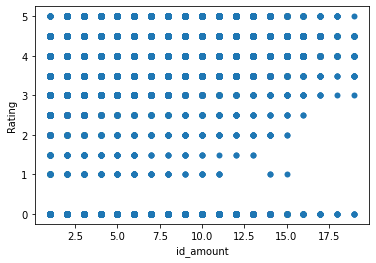

In [27]:
sns.scatterplot(x="id_amount", y="Rating",
                sizes=(1, 8), linewidth=0,
                data=data)

Для крупных сетей ниже разброс ненулевых значений

### Price Range

In [28]:
data['Price Range'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

### 3. Преобразование и заполнение пропусков

In [29]:
# Пометка данных имеющих пропуски
data['price_class_nan'] = pd.isna(data['Price Range']).astype('uint8')

In [30]:
#Создание словоря для преобразования класса цены в число, где 1 - самые дешевые рестораны.
mapping_dict = {data['Price Range'].unique()[0]: 2,
                data['Price Range'].unique()[2]: 3,
                data['Price Range'].unique()[3]: 1}

In [31]:
# Преобразование признака в числовой формат для работы с пропусками
data['price_class'] = data['Price Range'].map(mapping_dict)

In [32]:
# Функция вычисления среднего класса по городу и квинтилю Ranking для города
def main_price(city, i):
    data_c = data[data.City == city]
    result = data_c[(data_c.Ranking.quantile(i) <= data_c.Ranking) & (data_c.Ranking < data_c.Ranking.quantile(i+0.2))].price_class.dropna().mean()
    return result

In [33]:
# Функция вычисляющая скрию значений по городам для определенного квинтиля
def quantile(quantile):
    series=[]
    for i in data.City.unique():
        series.append(main_price(i, quantile))
    return series

In [34]:
# Создание DF c итоговыми значениями
city_price = pd.DataFrame({'city': data.City.unique()})
quantiles = [x/10 for x in range(8, -1, -2)]
for i in quantiles:
    city_price[i]=quantile(i)

In [35]:
city_price

,city,0.8,0.6,0.4,0.2,0.0
0,Paris,1.533940,1.519600,1.767169,2.053082,2.092891
1,Helsinki,1.548387,1.631579,1.612903,2.076923,2.120482
2,Edinburgh,1.790541,1.843537,2.344595,2.258503,2.103704
3,London,1.670688,1.650355,1.853418,2.188612,2.135899
4,Bratislava,1.360000,1.315789,1.447368,1.573333,2.111111
5,Lisbon,1.616564,1.530488,1.777778,2.170347,2.234528
6,Budapest,1.803922,1.591133,1.777228,2.163366,2.203297
7,Stockholm,1.406863,1.341463,1.441748,1.763547,2.027473
8,Rome,1.659491,2.041833,2.154762,2.172414,2.220833
9,Milan,1.474766,1.415094,1.747170,2.145873,2.210638


В большинстве случаев, среднеарифметический класс соответствует самому популярному значению в DF (средний). Тем не менее, иммется ряд исключений.

In [36]:
#Создание списка содержащего вложенный список [город-квинтиль],
#где преоблядают дешевые рестораны.
class1_price=[]
for i in quantiles:
    for j in city_price[city_price[i]<1.5].city:
        class1_price.append([j, i])
class1_price

[['Bratislava', 0.8],
 ['Stockholm', 0.8],
 ['Milan', 0.8],
 ['Hamburg', 0.8],
 ['Vienna', 0.8],
 ['Madrid', 0.8],
 ['Berlin', 0.8],
 ['Lyon', 0.8],
 ['Zurich', 0.8],
 ['Bratislava', 0.6],
 ['Stockholm', 0.6],
 ['Milan', 0.6],
 ['Hamburg', 0.6],
 ['Madrid', 0.6],
 ['Berlin', 0.6],
 ['Lyon', 0.6],
 ['Bratislava', 0.4],
 ['Stockholm', 0.4],
 ['Hamburg', 0.4]]

In [37]:
#Заполнение соответствующих значений
class1_indexes=[]
if len(class1_price)>0:
    #Цикл достает индексы строк соответствующих парам [город-квинтиль]
    for pair in class1_price:
        city = pair[0]
        Q = pair[1]
        df = data[(data.City == city) & (data[data.City == city].Ranking.quantile(Q) <= data.Ranking) & (data[data.City == city].Ranking < data.Ranking.quantile(Q+0.2))]
        #Цикл оставляет только пустые ячейки
        for i in df[df.price_class.isna()].index:
            class1_indexes.append(i)
    #Цикл заполния пустых значений
    for i in class1_indexes:
        data.xs(i)['price_class'] = 1   

<ipython-input-37-ec0c5ca8b16a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.xs(i)['price_class'] = 1


In [38]:
#Создание списка содержащего вложенный список [город-квинтиль], где преоблядают дорогие рестораны.
#Не сотря на то, что список пуст, он может быть актуален для других данных
class3_price=[]
for i in quantiles:
    for j in city_price[city_price[i]>=2.5].city:
        class1_price.append([j, i])
class3_price

[]

In [39]:
#Заполнение соответствующих значений аналогично дешевым ресторанам
class3_indexes=[]
if len(class3_price)>0:
    for pair in class3_price:
        city = pair[0]
        Q = pair[1]
        df = data[(data.City == city) & (data[data.City == city].Ranking.quantile(Q) <= data.Ranking) & (data[data.City == city].Ranking < data.Ranking.quantile(Q+0.2))]
        for i in df[df.price_class.isna()].index:
            class3_indexes.append(i)
    for i in class3_indexes:
        data.xs(i)['price_class'] = 1 

In [40]:
#Заполнение оставшихся ячеек самым популярным значением
data.price_class.fillna(value = 2, inplace =True)

In [41]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,has_duplicate,id_amount,price_class_nan,price_class
41148,id_1886,Berlin,"['German', 'Cafe', 'Fast Food', 'European', 'V...",1888.0,$,48.0,"[['Quick and easy self-service', 'self service...",/Restaurant_Review-g187323-d8553789-Reviews-Ba...,d8553789,1,4.0,0,7,0,3.0
23150,id_796,Warsaw,NaN,797.0,NaN,32.0,[['Intimate little restaurant with good Georg....,/Restaurant_Review-g274856-d6651217-Reviews-Ar...,d6651217,1,4.0,0,13,1,1.0
39690,id_1058,Edinburgh,"['Cafe', 'Vegetarian Friendly']",1059.0,$$ - $$$,10.0,"[['Fabukous Filipino Food', 'Five months ago t...",/Restaurant_Review-g186525-d12211084-Reviews-C...,d12211084,1,4.5,0,11,0,2.0
34003,id_2880,Brussels,"['Belgian', 'European']",2881.0,$$ - $$$,5.0,"[['Great chocolate', 'Good chocolate'], ['12/1...",/Restaurant_Review-g188644-d12208932-Reviews-C...,d12208932,1,3.5,0,7,0,2.0
13812,id_2344,Hamburg,NaN,2348.0,NaN,13.0,"[['Hola senorita!', 'great coffee shop'], ['07...",/Restaurant_Review-g187331-d2149612-Reviews-Ma...,d2149612,1,3.5,0,7,1,1.0


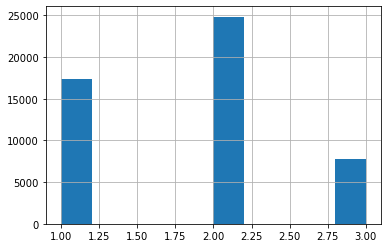

In [42]:
data['price_class'].hist()

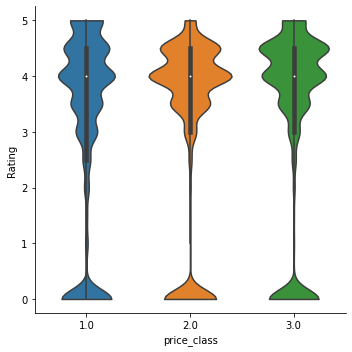

In [43]:
sns.catplot(x='price_class', y='Rating',
            kind="violin", bw=.1, cut=0,
            data=data)

### Cuisine Style

### 4. Преобразование и заполнение пропусков

In [44]:
# Пометка данных имеющих пропуски
data['cuisine_nan'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [45]:
#Создание списка из строки
data['Cuisine Style'] = data['Cuisine Style'].str.findall(r'\w+\s*\w*\s*\w*\s*\w*\s*\w*')

In [46]:
#Функция вычисляющая самую популярную кухню в городе.
#Значение "European" опущено, т.к. говорит о географическом происхождении не достаточно точно
def popular_cuisine(city):
    popular_values = pd.Series(data[data.City == city]['Cuisine Style'].dropna().sum()).value_counts()
    if popular_values.index[0] != 'European':
        result = popular_values.index[0]
    else:
        result = popular_values.index[1]
    return result

In [47]:
#Создание вспомогательного DF для более быстрого заполнения пропусков
city_cuisine = pd.DataFrame({'city': data.City.unique()})
city_cuisine['cuisine'] = city_cuisine.city.apply(popular_cuisine)
city_cuisine

,city,cuisine
0,Paris,French
1,Helsinki,Vegetarian Friendly
2,Edinburgh,Vegetarian Friendly
3,London,Vegetarian Friendly
4,Bratislava,Central European
5,Lisbon,Portuguese
6,Budapest,Hungarian
7,Stockholm,Vegetarian Friendly
8,Rome,Italian
9,Milan,Italian


In [48]:
#Функция заполнения пропусков популярным значением для города
def associated_cuisine(city):
    result = city_cuisine[city_cuisine.city == city].iloc[0][1]
    return result

In [49]:
#Функция преобразования заполненных строк в список
def making_list(cell):
    if type(cell) == list:
        result = cell
    elif type(cell) == str:
        result = re.findall(r'\w+\s*\w*\s*\w*\s*\w*\s*\w*', cell)
    return result

In [50]:
#Применение вышеописанных функций + создание столбца кол-ва кухонь
data['Cuisine Style'].fillna(value=data.City.apply(associated_cuisine), inplace=True)
data['Cuisine Style'] = data['Cuisine Style'].apply(making_list)
data['cuisine_amount'] = data['Cuisine Style'].apply(lambda x: len(x))

### Reviews

### 5. Преобразование и создание доп. парметров

In [51]:
# Пропусков всего 2, можно заполнить самым популярным(пустым списом) значением
data.Reviews.fillna(data.Reviews.value_counts().index[0], inplace = True)

In [52]:
# Функция преобразоватия строковой даты в формат datetime
def date_conversion(cell):
    resulting_list=[]
    for i in cell:
        if int(i[:i.find('/')])<=12:
            converted_time = datetime.strptime(i, '%m/%d/%Y')
            resulting_list.append(converted_time)
        else:
            if '/' in i[-4:]:
                converted_time = datetime.strptime(i, '%d/%m/%y')
                resulting_list.append(converted_time)
            else:
                converted_time = datetime.strptime(i, '%d/%m/%Y')
                resulting_list.append(converted_time)
    return resulting_list

In [53]:
# Создание параметра review_dates содержащего список дат отзывов
data['review_dates'] = data.Reviews.str.findall(r'\d+/\d+/\d+')
data.review_dates = data.review_dates.dropna().apply(date_conversion)

In [54]:
# Фунция вычисляет разницу между превым и последним отзывом
def review_t_dif(cell):
    if len(cell)>=2:
        dif=max(cell)-min(cell)
    else:
        dif=timedelta(days = 0)
    return dif

In [55]:
# Параметр review_time_span отбражает разницу между превым и последним отзывом
data['review_time_span'] = data.review_dates.dropna().apply(review_t_dif)

In [56]:
#Перевод результата в секунды
data.review_time_span = data.review_time_span.apply(lambda x: x.total_seconds())

In [57]:
# Параметр visible_reviews отбражает кол-во видимых отзывов
data['visible_reviews'] = data.review_dates.apply(lambda x: len(x))

In [58]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,has_duplicate,id_amount,price_class_nan,price_class,cuisine_nan,cuisine_amount,review_dates,review_time_span,visible_reviews
40004,id_1640,Milan,"[Italian, Wine Bar, Mediterranean, European]",1642.0,$$ - $$$,275.0,"[['Apero Time!', 'cosy atmosphere, perfect ser...",/Restaurant_Review-g187849-d813345-Reviews-Dec...,d813345,1,4.0,0,9,0,2.0,0,4,"[2016-11-14 00:00:00, 2015-08-24 00:00:00]",38707200.0,2
20344,id_11857,Paris,"[Italian, Pizza]",11859.0,$$ - $$$,7.0,"[['best coffee in town', 'Best pizza ever!'], ...",/Restaurant_Review-g187147-d2623241-Reviews-La...,d2623241,1,4.0,0,1,0,2.0,0,2,"[2015-02-03 00:00:00, 2014-08-15 00:00:00]",14860800.0,2
31546,id_7708,Barcelona,[Italian],7710.0,$$$$,2.0,"[[], []]",/Restaurant_Review-g187497-d1423002-Reviews-Pa...,d1423002,1,3.0,0,2,0,2.0,0,1,[],0.0,0
7846,id_7846,Hamburg,[Greek],1165.0,NaN,6.0,"[[], []]",/Restaurant_Review-g187331-d8701015-Reviews-Re...,d8701015,0,0.0,0,3,1,1.0,0,1,[],0.0,0
2233,id_2233,Paris,"[Italian, Pizza, International]",11539.0,$$ - $$$,48.0,"[['Good, housemade Pizza', 'Great meal!!'], ['...",/Restaurant_Review-g187147-d3583486-Reviews-Ni...,d3583486,0,0.0,0,8,0,2.0,0,3,"[2017-04-10 00:00:00, 2018-01-04 00:00:00]",23241600.0,2


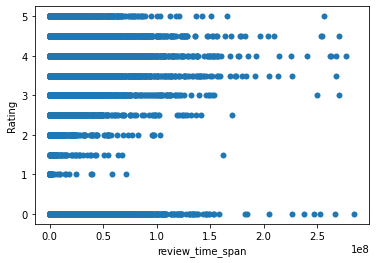

In [59]:
sns.scatterplot(x='review_time_span', y='Rating',
                sizes=(1, 8), linewidth=0,
                data=data)

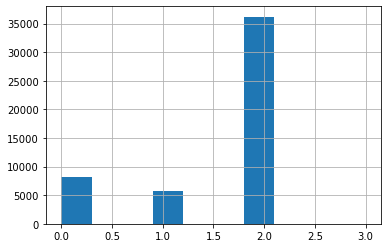

In [60]:
data['visible_reviews'].hist()

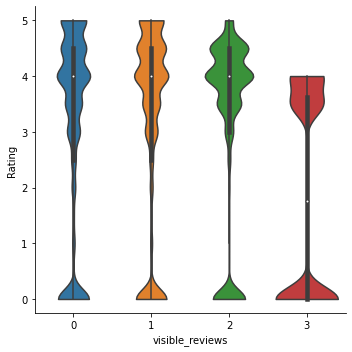

In [61]:
sns.catplot(x='visible_reviews', y='Rating',
            kind="violin", bw=.1, cut=0,
            data=data)

### 6. Применение списков ключевых слов для данных

In [62]:
# Параметр review_wordbox включает список слов используемых в Reviews
data.Reviews = data.Reviews.apply(lambda x: x.lower())
data['review_wordbox'] = data.Reviews.str.findall(r'\w[a-z]+')

In [63]:
# Все слова, встречающиеся более 2 раз у ресторанов с целевой переменной от 4.5
wordbox_positive = pd.Series(data[(data['sample'] == 1)&(data.Rating>=4.5)].review_wordbox.sum())
p_words = pd.DataFrame(wordbox_positive.value_counts())
p_words = p_words[p_words[0]>2]

In [64]:
# Все слова, встречающиеся более 2 раз у ресторанов с целевой переменной до 3.5
wordbox_negative = pd.Series(data[(data['sample'] == 1)&(data.Rating<=3.5)].review_wordbox.sum())
n_words = pd.DataFrame(wordbox_negative.value_counts())
n_words = n_words[n_words[0]>2]

In [65]:
# Слова, уникальные для ресторанов с высоким рейтингом
positive_review_predictors = []
for i in p_words.index:
    if i not in list(n_words.index):
        positive_review_predictors.append(i)

In [66]:
# Слова, уникальные для ресторанов с низким рейтингом
negative_review_predictors = []
for i in n_words.index:
    if i not in list(p_words.index):
        negative_review_predictors.append(i)

In [67]:
# Функция расчитывающая рейтинг по ключевым словам. Нейтральное значение = 0.5
def valued_review_score(wordbox):
    positives = 1
    negatives = 1
    for i in wordbox:
        if i in positive_review_predictors:
            positives += 1
        elif i in negative_review_predictors:
            negatives += 1
    result = positives/(positives + negatives)
    return result

In [68]:
# Параметр valued_review содержит условный рейтинг, расчитаный на осонове слов, содежащихся в Reviews
data['valued_review'] = data.review_wordbox.apply(valued_review_score)

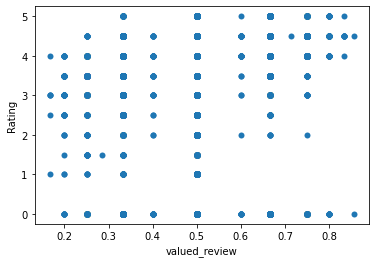

In [69]:
sns.scatterplot(x='valued_review', y='Rating',
                sizes=(1, 8), linewidth=0,
                data=data)

### Number of Reviews

### 7. Заполнение пропусков

In [70]:
# Пометка данных имеющих пропуски
data['NoF_nan'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [71]:
# Функция вычисления среднего класса по городу и квинтилю Ranking для города
def avg_reviews(city, i):
    data_c = data[data.City == city]
    result = data_c[(data_c.Ranking.quantile(i) <= data_c.Ranking) & (data_c.Ranking < data_c.Ranking.quantile(i+0.2))]['Number of Reviews'].dropna().mean()
    return result

In [72]:
# Функция вычисляющая серию значений по городам для определенного квинтиля
def quantile(quantile):
    series=[]
    for i in data.City.unique():
        series.append(avg_reviews(i, quantile))
    return series

In [73]:
# Создание DF c итоговыми значениями
city_rev = pd.DataFrame({'city': data.City.unique()})
quantiles = [x/10 for x in range(8, -1, -2)]
for i in quantiles:
    city_rev[i]=quantile(i)

In [74]:
city_rev

,city,0.8,0.6,0.4,0.2,0.0
0,Paris,46.227671,32.048171,54.307831,113.829648,321.429624
1,Helsinki,16.154762,21.681818,18.752941,42.726316,216.768421
2,Edinburgh,31.985612,36.416058,87.080537,237.731544,766.885906
3,London,29.160661,27.455657,44.912870,120.276773,437.715080
4,Bratislava,23.000000,9.773585,16.763158,24.559322,158.868421
5,Lisbon,47.344156,18.779720,29.088652,88.729483,421.203030
6,Budapest,38.441341,16.273224,26.584337,72.117647,585.289216
7,Stockholm,25.558011,14.505747,22.255435,47.490291,244.251208
8,Rome,59.378685,95.349421,192.789168,307.079151,760.370656
9,Milan,52.616000,43.648033,62.199203,174.916512,479.510204


In [75]:
# Функция возвращает соответсвующее значение из city_rev по City и Ranking
def aprx_rev_amount(x):
    d = data[data.City == x['City']]
    quantiles = [n/10 for n in range(8, -1, -2)]
    for i in quantiles:
        if d.Ranking.quantile(i) <= x['Ranking'] <= d.Ranking.quantile(i+0.2):
            result = float(int(city_rev[city_rev.city == x['City']][i]))
    return result

In [76]:
# Создание серии, содержащей индексы пустых значений с соответствующее значение из city_rev
# fillna() не ипользовал, т.к. рачеты занимали больше времени
reviews_for_nan = data[data['Number of Reviews'].isna() == True].apply(aprx_rev_amount, axis=1)

In [77]:
# Заполнение пропусков в основном DF
for i in list(reviews_for_nan.index):
    data['Number of Reviews'].loc[i] = reviews_for_nan[i]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Ranking

### 8. Нормолизация в зависимости от City

In [78]:
# Создание словаря, содержащего пары город: длинна вектора Ranking по городу
v_lengths = {}
for i in list(data.City.unique()):
    v_lengths[i] = np.linalg.norm(data[data.City == i].Ranking)

In [79]:
# Функция возражает произведение значения Ranking и длинны вектора Ranking по городу
def normalization(row):
    result = row.Ranking/v_lengths[row.City]
    return result

In [80]:
# Параметр ranking_norm содержит нормализованный Ranking
data['ranking_norm'] = data.apply(normalization, axis = 1)

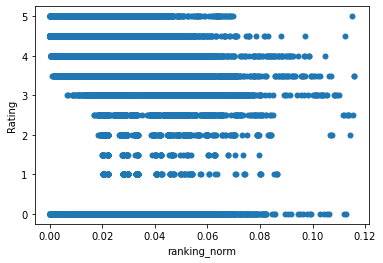

In [81]:
sns.scatterplot(x='ranking_norm', y='Rating',
                sizes=(1, 8), linewidth=0,
                data=data)

### City

### 9. Создание доп. параметров на основе City

In [82]:
#Создание списка уникальных значений City
city_state = pd.DataFrame({'city': data.City.unique()})

In [83]:
# Функция возвращает код страны по названию города
def country(city):
    coordinates = geolocator.geocode(city)[1]
    location = geolocator.reverse(coordinates, exactly_one=True)
    address = location.raw['address']
    country = address.get('country_code', '')
    return country

In [84]:
# Функция возвращает население по названию города и коду страны 
def city_population(row):
    city = row.city
    country = row.country
    tmp = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=worldcitiespop&q=%s&sort=population&facet=country&refine.country=%s'
    cmd = tmp % (city, country)
    res = requests.get(cmd)
    dct = json.loads(res.content)
    info = dct['records'][0]['fields']
    if 'population' in info.keys():
        result = info['population']
    else:
        result = 0
    return result

In [85]:
# Применение функций, перевод кода страны в верхгий регистр, замена на название страны по коду
city_state['country'] = city_state.city.apply(country)
city_state['population'] = city_state.apply(city_population, axis = 1)
city_state.country = city_state.country.apply(lambda x: x.upper())
city_state.country = city_state.country.apply(lambda x: pycountry.countries.get(alpha_2=x).name)

In [86]:
# Список с GIT, содержащий пары страна, прилагательное
demonyms = pd.read_csv('demonyms.csv')

In [87]:
# Функция возвращает список прилагательных соответствующих стране
# Если функция возващает пустой список, сокращенное название страны меняется на официальное
def adjectives(country):
    result = list(demonyms[demonyms.Aalborg == country].Aalborgenser)
    if len(result) == 0:
        alternative = pycountry.countries.get(name=country).official_name
        result = list(demonyms[demonyms.Aalborg == alternative].Aalborgenser)
    return result

In [88]:
# Применение функции
city_state['adjectives'] = city_state.country.apply(adjectives)

In [89]:
city_state

,city,country,population,adjectives
0,Paris,France,2110694,"[French, Frenchman, Frenchwoman]"
1,Helsinki,Finland,558457,"[Finn, Finnic, Finnish]"
2,Edinburgh,United Kingdom,435794,"[British, Uk]"
3,London,United Kingdom,7421228,"[British, Uk]"
4,Bratislava,Slovakia,423737,"[Slovak, Slovakian]"
5,Lisbon,Portugal,517798,[Portuguese]
6,Budapest,Hungary,1708088,"[Hungarian, Magyar]"
7,Stockholm,Sweden,1253309,"[Swede, Swedish]"
8,Rome,Italy,2643736,[Italian]
9,Milan,Italy,1156903,[Italian]


In [90]:
# Функция заполняет параметр native_cuisine.
# ==1, если один из тегов Cuisine Style совпадает с прилагательными города
def native(row):
    result = 0
    for i in city_state[city_state.city == row.City].adjectives.sum():
        if i in row['Cuisine Style']:
            result = 1
    return result

In [91]:
# Параметр native_cuisine отбражает евляется ли кухня национальной
data['native_cuisine'] = data.apply(native, axis = 1)

In [92]:
#Создание словоря с парами город - население
mapping_population = {}
for i in city_state.index:
    mapping_population[city_state.city[i]]=city_state.population[i]

In [93]:
# Добавление населения
# Создания параметра отнашения населения и ранка ресторана.
# Таким образом, наибольшим значением обладают высокоранговые рестораны в больших городах
data['city_population'] = data.City.map(mapping_population)
data['feature_1']=data['city_population']/data['Ranking']

In [94]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,review_dates,review_time_span,visible_reviews,review_wordbox,valued_review,NoF_nan,ranking_norm,native_cuisine,city_population,feature_1
33369,id_8785,Paris,"[Italian, French, Pizza]",8787.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187147-d7273105-Reviews-Ch...,d7273105,1,...,[],0.0,0,[],0.500000,0,0.014004,1,2110694,240.206441
37126,id_807,Rome,"[Italian, Pizza, Mediterranean, Vegetarian Fri...",808.0,$$ - $$$,759.0,"[['very good', 'first meal in rome'], ['11/28/...",/Restaurant_Review-g187791-d1520829-Reviews-Br...,d1520829,1,...,"[2017-11-28 00:00:00, 2017-11-21 00:00:00]",604800.0,2,"[very, good, first, meal, in, rome]",0.500000,0,0.004628,1,2643736,3271.950495
7899,id_7899,Budapest,"[American, Fast Food]",1002.0,$,25.0,"[['the ritz of mcdonalds', 'like any other'], ...",/Restaurant_Review-g274887-d4802533-Reviews-Mc...,d4802533,0,...,"[2018-01-08 00:00:00, 2017-12-27 00:00:00]",1036800.0,2,"[the, ritz, of, mcdonalds, like, any, other]",0.333333,0,0.022283,0,1708088,1704.678643
32833,id_4027,Berlin,[Fast Food],4029.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187323-d12951681-Reviews-J...,d12951681,1,...,[],0.0,0,[],0.500000,0,0.020781,0,3398362,843.475304
1859,id_1859,Lisbon,[Portuguese],2016.0,NaN,10.0,"[['välipala - snack'], ['09/29/2016']]",/Restaurant_Review-g189158-d6782118-Reviews-Pa...,d6782118,0,...,[2016-09-29 00:00:00],0.0,1,"[älipala, snack]",0.500000,0,0.023080,1,517798,256.844246


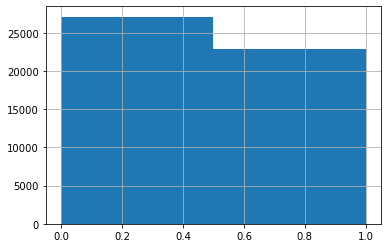

In [95]:
data['native_cuisine'].hist(bins=2)

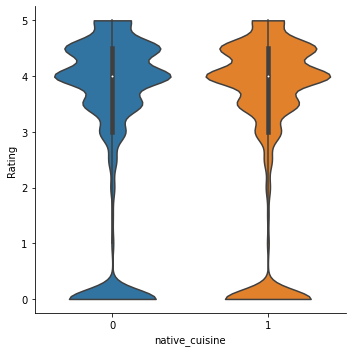

In [96]:
sns.catplot(x='native_cuisine', y='Rating',
            kind="violin", bw=.1, cut=0,
            data=data)

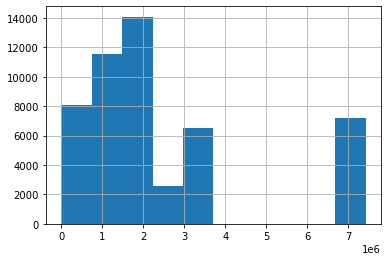

In [97]:
data['city_population'].hist(bins=10)

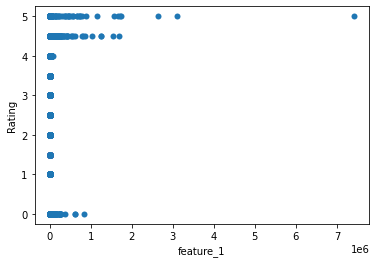

In [98]:
sns.scatterplot(x='feature_1', y='Rating',
                sizes=(1, 8), linewidth=0,
                data=data)

# Промежуточный итог

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      50000 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  50000 non-null  float64
 6   Reviews            50000 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  has_duplicate      50000 non-null  int64  
 12  id_amount          50000 non-null  int64  
 13  price_class_nan    50000 non-null  uint8  
 14  price_class        50000 non-null  float64
 15  cuisine_nan        50000 non-null  uint8  
 16  cuisine_amount     500

In [100]:
data.describe()

,Ranking,Number of Reviews,sample,Rating,has_duplicate,id_amount,price_class_nan,price_class,cuisine_nan,cuisine_amount,review_time_span,visible_reviews,valued_review,NoF_nan,ranking_norm,native_cuisine,city_population,feature_1
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,5.000000e+04
mean,3664.427520,118.427320,0.800000,3.194430,0.001480,6.809000,0.347220,1.809100,0.231800,2.625860,8.918421e+06,1.561920,0.504851,0.064000,0.019661,0.457540,2.451953e+06,3.299993e+03
std,3700.092452,285.501736,0.400004,1.705453,0.038443,4.249965,0.476091,0.683452,0.421986,1.824386,1.726383e+07,0.755577,0.079872,0.244755,0.015278,0.498199,2.214010e+06,4.709505e+04
min,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,0.166667,0.000000,0.000001,0.000000,0.000000e+00,0.000000e+00
25%,972.000000,10.000000,1.000000,3.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.500000,0.000000,0.008175,0.000000,1.089958e+06,3.921944e+02
50%,2278.000000,32.000000,1.000000,4.000000,0.000000,6.000000,0.000000,2.000000,0.000000,2.000000,2.505600e+06,2.000000,0.500000,0.000000,0.016512,0.000000,1.651676e+06,6.937961e+02
75%,5241.000000,105.000000,1.000000,4.500000,0.000000,10.000000,1.000000,2.000000,0.000000,4.000000,1.036800e+07,2.000000,0.500000,0.000000,0.027194,1.000000,3.102644e+06,1.391583e+03
max,16444.000000,9660.000000,1.000000,5.000000,1.000000,19.000000,1.000000,3.000000,1.000000,21.000000,2.847744e+08,3.000000,0.857143,1.000000,0.115852,1.000000,7.421228e+06,7.421228e+06


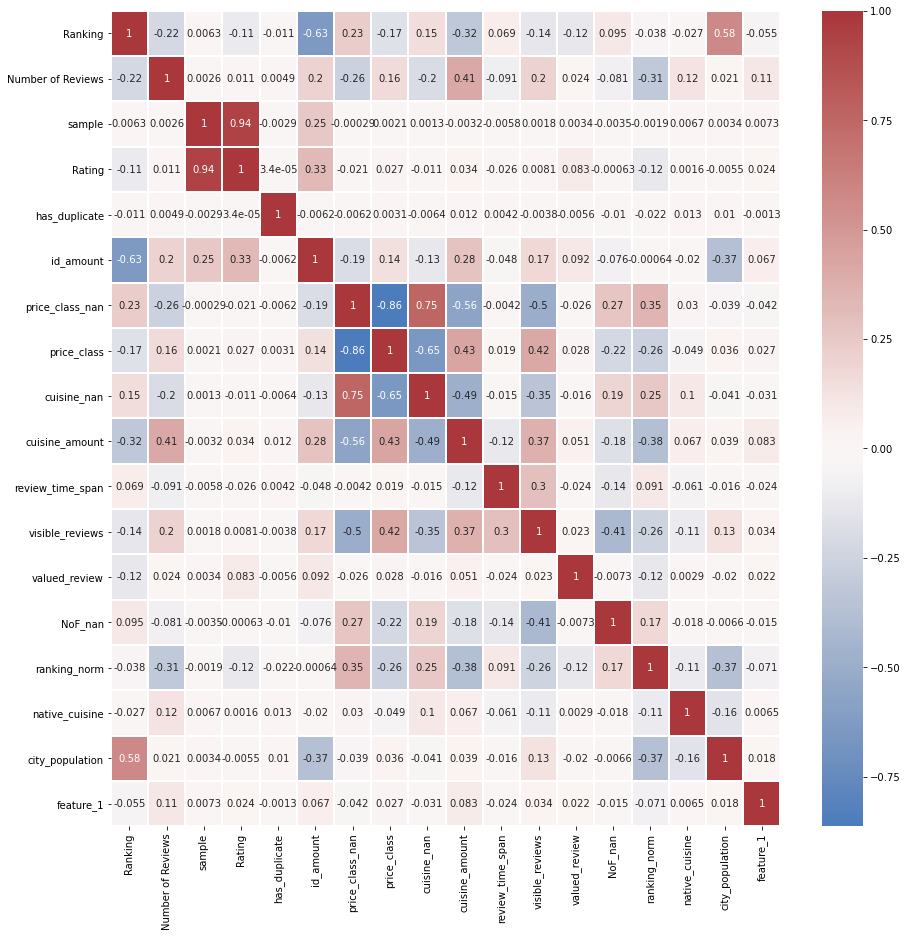

In [101]:
correlation = data.corr()
ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation, annot=True, cmap='vlag', linewidths=1, center=0)

## 10. Dummy-variables

![](https://i.imgur.com/mtimFxh.png)

### 10.1 City

In [102]:
# Создаем сетку
data = pd.get_dummies(data, columns=[ 'City'], dummy_na=False)

In [103]:
data.sample(3)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
42171,id_9042,[Italian],9051.0,NaN,44.0,"[[], []]",/Restaurant_Review-g186338-d10396602-Reviews-T...,d10396602,1,5.0,...,0,0,0,0,0,0,0,0,0,0
2690,id_2690,"[Seafood, European, Portuguese]",3632.0,$$ - $$$,19.0,"[['short break with my wife in lisbon', 'poor ...",/Restaurant_Review-g189158-d13205929-Reviews-G...,d13205929,0,0.0,...,0,0,0,0,0,0,0,0,0,0
40155,id_4482,"[Italian, Bar, Pub]",4483.0,$,81.0,"[['good drinks with great free snacks', 'delic...",/Restaurant_Review-g187791-d1860448-Reviews-Ba...,d1860448,1,4.5,...,0,0,0,0,0,1,0,0,0,0


### 10.2 Cuisine Style

In [104]:
# Функция для заполнения категории Cuisine Style
def dummy_cuisine(cell):
    if item in cell:
        return 1
    return 0

In [105]:
# Список уникальных значений переменной
all_cuisines = pd.Series(data['Cuisine Style'].sum()).unique()

In [106]:
# Применение функции
for item in all_cuisines:
    data[item] = data['Cuisine Style'].apply(dummy_cuisine)

In [107]:
data.sample(3)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
20498,id_1311,"[Mediterranean, Turkish, Middle Eastern, Veget...",1314.0,$$ - $$$,48.0,"[['so tasty', 'superb turkish cuisine'], ['11/...",/Restaurant_Review-g188590-d3539613-Reviews-Re...,d3539613,1,4.0,...,0,0,0,0,0,0,0,0,0,0
25059,id_4949,[French],4950.0,NaN,61.0,"[['perfect !', 'great cocktials'], ['10/05/201...",/Restaurant_Review-g187147-d8319689-Reviews-Ba...,d8319689,1,4.0,...,0,0,0,0,0,0,0,0,0,0
24174,id_7244,"[Chinese, Asian]",7249.0,$$ - $$$,120.0,"[['mustard with dim sum? way too expensive!', ...",/Restaurant_Review-g187514-d2374255-Reviews-Ko...,d2374255,1,3.5,...,0,0,0,0,0,0,0,0,0,0


### 10.3 Price Range

In [108]:
# Создаем сетку
data = pd.get_dummies(data, columns=[ 'price_class'], dummy_na=False)

In [109]:
data.sample(3)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,price_class_1.0,price_class_2.0,price_class_3.0
4555,id_4555,[Vegetarian Friendly],555.0,NaN,64.0,"[['oasis of relaxation', 'the best tea in irel...",/Restaurant_Review-g186605-d5821550-Reviews-Te...,d5821550,0,0.0,...,0,0,0,0,0,0,0,1,0,0
12094,id_307,"[French, European, Vegetarian Friendly]",308.0,$$$$,703.0,"[['delicious food + excellent service', 'best ...",/Restaurant_Review-g187147-d719817-Reviews-Bis...,d719817,1,4.5,...,0,0,0,0,0,0,0,0,1,0
7013,id_7013,"[Middle Eastern, Persian, Halal]",11684.0,$$ - $$$,40.0,"[['great', 'very efficient and very tasty'], [...",/Restaurant_Review-g186338-d2530110-Reviews-Pe...,d2530110,0,0.0,...,0,0,0,0,0,0,0,0,1,0


> # Предобработка

Не стал писать футкцию для предобработки, т.к. задействованно достаточно много сторонних источников и вспомогательных таблиц.

## Очистка от строк/списков

In [110]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']

In [111]:
object_columns

['Restaurant_id',
 'Cuisine Style',
 'Price Range',
 'Reviews',
 'URL_TA',
 'ID_TA',
 'review_dates',
 'review_wordbox']

In [112]:
data.drop(object_columns, axis = 1, inplace=True)

In [113]:
df_preproc = data
df_preproc.sample(5)

,Ranking,Number of Reviews,sample,Rating,has_duplicate,id_amount,price_class_nan,cuisine_nan,cuisine_amount,review_time_span,...,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,price_class_1.0,price_class_2.0,price_class_3.0
20563,11093.0,5.0,1,4.0,0,1,1,0,1,1555200.0,...,0,0,0,0,0,0,0,1,0,0
43148,6375.0,30.0,1,4.0,0,3,0,0,2,10540800.0,...,0,0,0,0,0,0,0,0,1,0
3226,2779.0,6.0,0,0.0,0,4,0,0,2,34819200.0,...,0,0,0,0,0,0,0,0,1,0
25406,5337.0,10.0,1,4.5,0,2,1,0,3,29721600.0,...,0,0,0,0,0,0,0,1,0,0
15246,691.0,183.0,1,4.5,0,11,0,0,4,691200.0,...,0,0,0,0,0,0,0,0,1,0


In [114]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 177 entries, Ranking to price_class_3.0
dtypes: float64(7), int64(133), uint8(37)
memory usage: 55.2 MB


## Разделение данных

In [115]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [116]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [117]:
# Проверка
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 176), (40000, 176), (40000, 175), (32000, 175), (8000, 175))

# Model 
Сам ML

In [118]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [119]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [120]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [121]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20373499999999997


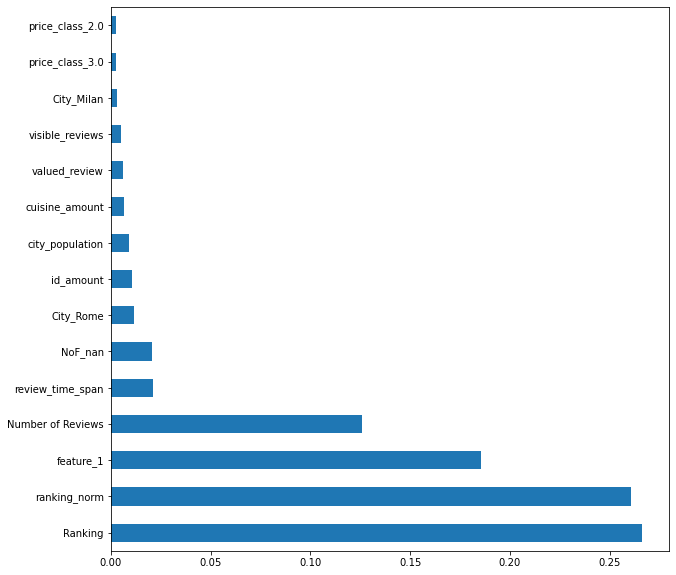

In [122]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [123]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,has_duplicate,id_amount,price_class_nan,cuisine_nan,cuisine_amount,review_time_span,visible_reviews,...,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,price_class_1.0,price_class_2.0,price_class_3.0
2783,12017.0,3.0,0.0,0,6,1,1,1,13651200.0,2,...,0,0,0,0,0,0,0,1,0,0
8817,2396.0,86.0,0.0,0,1,0,0,4,1555200.0,2,...,0,0,0,0,0,0,0,0,1,0
5415,7455.0,43.0,0.0,0,5,0,0,2,33868800.0,2,...,0,0,0,0,0,0,0,0,1,0
9450,3049.0,12.0,0.0,0,2,0,0,1,0.0,0,...,0,0,0,0,0,0,0,0,1,0
9666,2080.0,18.0,0.0,0,1,1,1,1,7171200.0,2,...,0,0,0,0,0,0,0,1,0,0
3791,3058.0,301.0,0.0,0,4,0,0,3,16934400.0,2,...,0,0,0,0,0,0,0,0,1,0
1225,2383.0,63.0,0.0,0,11,0,0,5,11750400.0,2,...,0,0,0,0,0,0,0,0,0,1
523,1013.0,111.0,0.0,0,12,0,0,4,432000.0,2,...,0,0,0,0,0,0,0,0,1,0
5923,112.0,96.0,0.0,0,3,0,0,6,259200.0,2,...,0,0,0,0,0,0,0,0,1,0
7632,746.0,141.0,0.0,0,3,0,0,6,4233600.0,2,...,0,0,0,0,0,0,0,0,0,1


In [124]:
test_data = test_data.drop(['Rating'], axis=1)

In [125]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [126]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [127]:
predict_submission

array([3.095, 4.325, 4.4  , ..., 3.12 , 4.485, 4.31 ])

In [128]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.095
1,id_1,4.325
2,id_2,4.400
3,id_3,4.340
4,id_4,4.485
5,id_5,4.445
6,id_6,2.090
7,id_7,3.025
8,id_8,4.040
9,id_9,4.680
